In [1]:
import pandas as pd
import numpy as np
import re
import os

In [2]:
def base_no_horizontal(base):
    base = base[
        (base['porteria'].isna()) &
        (base['conjuntocerrado']==0) &
        (base['tipoinmueble']=='Casa') &
        (base['ascensor'].isna()) &
        ((base['gimmasio'].isna()) | (base['gimnasio']==0)) &
        (base['piscina'].isna()) & 
        ((base['area']<1500) & (base['area']>35)) & 
        (base['piso']<5) &
        ((base['habitaciones']<15) & (base['habitaciones']>0))
        #Si encontramos gimnasios en la geocodificación comparar con los puntos que se quitaron
    ]
    return base

In [3]:
carpeta_path = r'C:\Users\William\Desktop\el algoritmo es correcto'
archivo_train = r'train_data.csv'
path_train = os.path.join(carpeta_path, archivo_train)

In [4]:
path_train

'C:\\Users\\William\\Desktop\\el algoritmo es correcto\\train_data.csv'

In [5]:
train = pd.read_csv(
    path_train, 
    dtype={
        "tiempodeconstruido": str,
        "vista": str,
        "tipoinmueble": str,
        "tiponegocio": str,
        'valorventa': 'int64',
        # 'area': 'int64'
    }
)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244488 entries, 0 to 244487
Data columns (total 32 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     244488 non-null  int64  
 1   area                   244110 non-null  float64
 2   ascensor               87672 non-null   float64
 3   balcon                 60181 non-null   float64
 4   banos                  243049 non-null  float64
 5   banoservicio           12231 non-null   float64
 6   conjuntocerrado        244488 non-null  int64  
 7   cuartoservicio         55492 non-null   float64
 8   deposito               107413 non-null  float64
 9   estrato                236806 non-null  float64
 10  estudio                76686 non-null   float64
 11  garajes                212861 non-null  float64
 12  gimnasio               72755 non-null   float64
 13  habitaciones           243731 non-null  float64
 14  halldealcobas          64640 non-nul

In [7]:
train.head()

,id,area,ascensor,balcon,banos,banoservicio,conjuntocerrado,cuartoservicio,deposito,estrato,...,tiempodeconstruido,vigilancia,vista,zonalavanderia,valoradministracion,valorventa,tipoinmueble,tiponegocio,latitud,longitud
0,1205404,55.0,NaN,NaN,NaN,NaN,0,NaN,1.0,3.0,...,NaN,NaN,NaN,1.0,50000.0,169950000,Casa,Venta,4.560965,-74.094889
1,1204371,43.0,NaN,NaN,NaN,NaN,0,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,0.0,90000000,Casa,Venta,4.576960,-74.100083
2,1125353,360.0,NaN,NaN,NaN,NaN,0,NaN,0.0,3.0,...,NaN,NaN,NaN,NaN,0.0,1100000000,Casa,Venta,4.575000,-74.101000
3,1125506,60.0,NaN,NaN,NaN,1.0,0,1.0,0.0,3.0,...,NaN,NaN,NaN,NaN,0.0,260000000,Apartamento,Venta,4.575924,-74.108039
4,1204569,72.0,NaN,NaN,NaN,NaN,0,NaN,0.0,2.0,...,NaN,NaN,NaN,1.0,0.0,125000000,Casa,Venta,4.559000,-74.097000


In [8]:
for columna in train.columns:
    if columna not in ['id', 'valoradministracion', 'valorventa', 'latitud', 'longitud']:
        print("{}: ".format(columna), train[columna].unique())

area:  [ 55.    43.   360.   ...  31.74  44.32  62.47]
ascensor:  [nan  1.]
balcon:  [nan  1.]
banos:  [ nan   0.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  23.  24.  25.  26.  27.  44.
   1.  35. 253.  71.  40.  33.]
banoservicio:  [nan  1.]
conjuntocerrado:  [0 1]
cuartoservicio:  [nan  1.]
deposito:  [ 1.  0. nan]
estrato:  [ 3. nan  2.  4.  5.  6.  1.  7.  0.]
estudio:  [nan  1.  0.]
garajes:  [nan  1.  2.  4.  3.  0.  5.  6. 10.  7.  9.  8.]
gimnasio:  [ 0.  1. nan]
habitaciones:  [  2.   3.  nan   5.   1.   4.  14.  10.   0.  17.  43.   6.  11.   9.
   8.  15.  12.   7.  18.  21.  30.  40.  23.  20.  34.  13.  33.  19.
  16.  85.  22.  24.  28.  25.  35.  32.  27.  26.  52. 253.  88.]
halldealcobas:  [nan  1.]
parqueaderovisitantes:  [nan  1.  0.]
piscina:  [nan  1.]
piso:  [nan  1.  2.  4.  3.  6.  9.  5.  7. 14. 13. 10. 11.  8. 12. 16. 15. 23.
 20. 17. 21. 18. 27. 19. 26. 28. 24. 22. 25. 30. 29.]
porteria:  [nan  1.]
re

In [9]:
prueba = train[
    (train['porteria'].isna()) &
    (train['conjuntocerrado']==0) &
    (train['tipoinmueble']=='Casa') &
    (train['ascensor'].isna()) &
    ((train['gimnasio'].isna()) | (train['gimnasio']==0)) &
    (train['piscina'].isna()) &
    ((train['area']<1500) & (train['area']>35)) &
    ((train['piso']<5) | (train['piso'].isna())) &
    ((train['habitaciones']<15) & (train['habitaciones']>0))
]#.groupby(['estrato','banos'], as_index=False).agg(**{'Cantidad': pd.NamedAgg('area', 'count')}).head(30)

In [10]:
prueba.shape

(40678, 32)

In [11]:
#Columnas a categóricas
columnas_categoricas = ['piso', 'tiempodeconstruido', 'vigilancia', 'vista', 'zonalavanderia']
for columna in columnas_categoricas:
    prueba[columna] = np.where(
        prueba[columna].notna(), prueba[columna], 'No define'
    ).astype(str)


ipykernel_launcher:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
# columnas que no serán usadas
columnas_no_usar = ['ascensor', 'tipoinmueble', 'porteria', 'conjuntocerrado', 'gimnasio', 'piscina', 'valoradministracion','tiponegocio']
prueba = prueba.drop(columns = columnas_no_usar)

In [13]:
prueba['banos'] = np.where(
    prueba['banos']==0,
    1,
    np.where(
        prueba['banos']>5,
        5,
        np.where(
            prueba['banos'].isna(),
            1,
            prueba['banos']
        )
    )
)

In [14]:
prueba['garajes'] = np.where(
    prueba['garajes']>4,
    5,
    np.where(
        prueba['garajes']<=4,
        prueba['garajes'],
        'No define'
    )
).astype(str)

In [15]:
prueba['deposito'] = np.where(
    prueba['deposito']==0,
    'No',
    np.where(
        prueba['deposito']==1,
        'Si',
        'No define'
    )
)

In [16]:
prueba['piso'].unique()

array(['No define', '3.0', '1.0', '2.0', '4.0'], dtype=object)

In [17]:
prueba['vista'] = np.where(
    prueba['vista'].notna(),
    prueba['vista'],
    'No defina'
)

In [18]:
prueba['zonalavanderia'] = np.where(
    prueba['deposito'].isna(),
    'No define',
    1
).astype(str)

In [19]:
columnas_valor0 = [
    'balcon', 'banoservicio', 'cuartoservicio', 'estudio', 'halldealcobas', 
    'remodelado', 'parqueaderovisitantes', 'saloncomunal','terraza']
prueba[columnas_valor0] = prueba[columnas_valor0].fillna(0)

In [20]:
#PENDIENTE GARAJE
# Piso y tiempo de construido, vigilancia, vista, zonalavanderia a categorica con no define
# No sirve, piscina, gimnasio, tiponegocio
prueba.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40678 entries, 0 to 244487
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     40678 non-null  int64  
 1   area                   40678 non-null  float64
 2   balcon                 40678 non-null  float64
 3   banos                  40678 non-null  float64
 4   banoservicio           40678 non-null  float64
 5   cuartoservicio         40678 non-null  float64
 6   deposito               40678 non-null  object 
 7   estrato                39196 non-null  float64
 8   estudio                40678 non-null  float64
 9   garajes                40678 non-null  object 
 10  habitaciones           40678 non-null  float64
 11  halldealcobas          40678 non-null  float64
 12  parqueaderovisitantes  40678 non-null  float64
 13  piso                   40678 non-null  object 
 14  remodelado             40678 non-null  float64
 15  s

<AxesSubplot:>

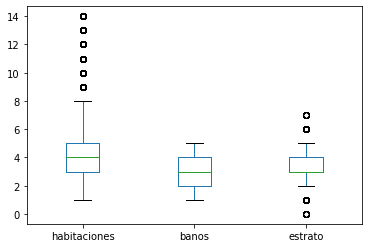

In [21]:
prueba[['habitaciones', 'banos', 'estrato']].plot(kind = 'box')

In [22]:
prueba['y'] = prueba['valorventa']/prueba['area']

In [23]:
#Quitar super estigmas de valores muy altos por metro cuadrado
prueba = prueba[prueba['y']<prueba['y'].quantile(0.99).astype('int64')]

<AxesSubplot:title={'center':'y'}, xlabel='[estrato, habitaciones]'>

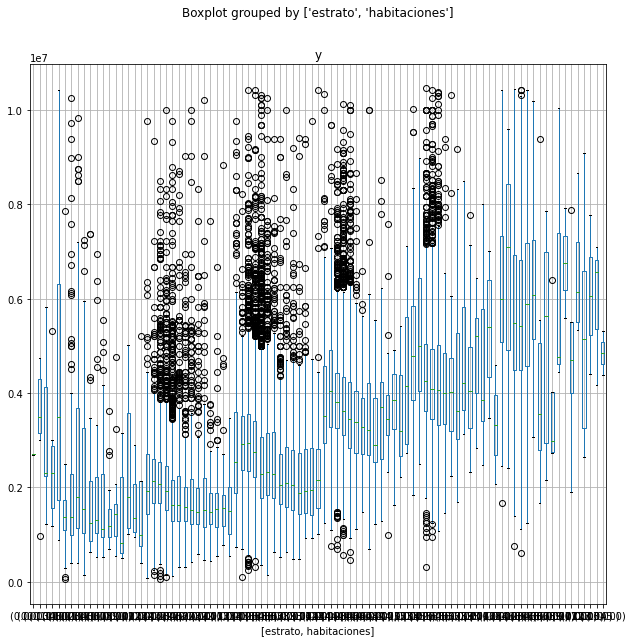

In [24]:
prueba[["y","estrato", "habitaciones"]].boxplot(by=["estrato", "habitaciones"], figsize=(10,10))

In [25]:
import geopandas

In [26]:
localidades_path = r'C:\Users\William\Desktop\el algoritmo es correcto\Datos abiertos bogota\localidades.json'
localidades = geopandas.read_file(localidades_path, crs={'init':'epsg:4686'})

In [27]:
# localidades_geo = localidades.plot(figsize=(10, 10), column='LocCodigo', zorder=1)

In [28]:
estratificacion_path = r'C:\Users\William\Desktop\el algoritmo es correcto\Datos abiertos bogota\manzana_estratificacion.json'
estratificacion = geopandas.read_file(estratificacion_path, crs={'init':'epsg:4686'})

In [29]:
estratificacion = estratificacion[['ESTRATO', 'geometry']]

In [30]:
casas = geopandas.GeoDataFrame(
    prueba, geometry=geopandas.points_from_xy(prueba.longitud, prueba.latitud), crs={'init': 'epsg:4326'})

C:\Users\William\AppData\Local\Programs\Python\Python37\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [31]:
# localidades_geo = localidades.plot(color='white', edgecolor='black', figsize=(10, 10), zorder=1)
# estratificacion_geo = estratificacion.plot(ax=localidades_geo, figsize=(10, 10), zorder=2, cmap='OrRd', legend=True)
# casas_geo = casas.plot(ax=localidades_geo, figsize=(10, 10), markersize=.1, zorder=3, marker='x')

In [32]:
estrato_intersectado = geopandas.sjoin(left_df=casas, right_df=estratificacion, how='left', op='intersects')

ipykernel_launcher:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326



In [33]:
estrato_intersectado['ESTRATO'] = np.where(
    estrato_intersectado['ESTRATO'].isna() | estrato_intersectado['ESTRATO']==0,
    np.NaN,
    estrato_intersectado['ESTRATO']
)

In [34]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

In [35]:
train = estrato_intersectado.loc[estrato_intersectado['ESTRATO'].notna(),['ESTRATO', 'latitud', 'longitud']]

In [36]:
X = train[['latitud', 'longitud']].values
y = train[['ESTRATO']].values
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [37]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(14693, 2)
(6297, 2)
(14693, 1)
(6297, 1)


In [38]:
# Se crea el modelo con la base de entrenamiento
resultados_train = {}
resultados_test = {}
for i in range(1,12):
    neigh = KNeighborsClassifier(n_neighbors=i, metric = 'euclidean')
    neigh.fit(X_train, y_train.ravel())
    resultados_train[i] = neigh.score(X_train, y_train)
    resultados_test[i] = neigh.score(X_test, y_test)

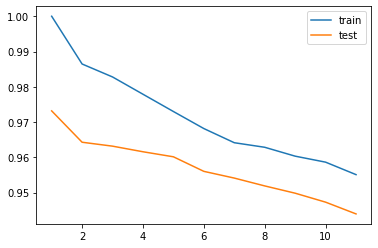

In [39]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(list(resultados_train.keys()), list(resultados_train.values()), label='train')
ax.plot(list(resultados_test.keys()), list(resultados_test.values()), label='test')
ax.legend()
plt.show()

In [40]:
neigh = KNeighborsClassifier(n_neighbors=3, metric = 'euclidean')
neigh.fit(X_train, y_train.ravel())
y_pred = neigh.predict(X_test)

In [41]:
print("R^2: {}".format(neigh.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))
print("Accuracy: {}".format(accuracy_score(y_test, y_pred)))

R^2: 0.9631570589169446
Root Mean Squared Error: 0.2637364818759819
Accuracy: 0.9631570589169446


In [42]:
valores = estrato_intersectado.loc[estrato_intersectado['ESTRATO'].isnull(),['latitud', 'longitud']].values

In [43]:
estrato_intersectado.loc[estrato_intersectado['ESTRATO'].isnull(),'ESTRATO'] = neigh.predict(valores)

In [44]:
estrato_intersectado.groupby(['ESTRATO'], as_index=False, dropna=False).agg(**{'Cantidad': pd.NamedAgg('latitud','count')})

,ESTRATO,Cantidad
0,1.0,830
1,2.0,7830
2,3.0,14462
3,4.0,8782
4,5.0,5661
5,6.0,2702


In [45]:
a = estrato_intersectado['estrato'] - estrato_intersectado['ESTRATO']
pd.DataFrame(a, columns=['Dif Estrato']).reset_index(drop=False).rename(columns={'index':'Cantidad'}).groupby('Dif Estrato', as_index=False, dropna=False).count()

,Dif Estrato,Cantidad
0,-6.0,2
1,-5.0,31
2,-4.0,65
3,-3.0,355
4,-2.0,924
5,-1.0,2917
6,0.0,30229
7,1.0,3366
8,2.0,585
9,3.0,202


In [46]:
estrato_intersectado.columns

Index(['id', 'area', 'balcon', 'banos', 'banoservicio', 'cuartoservicio',
       'deposito', 'estrato', 'estudio', 'garajes', 'habitaciones',
       'halldealcobas', 'parqueaderovisitantes', 'piso', 'remodelado',
       'saloncomunal', 'terraza', 'tiempodeconstruido', 'vigilancia', 'vista',
       'zonalavanderia', 'valorventa', 'latitud', 'longitud', 'y', 'geometry',
       'index_right', 'ESTRATO'],
      dtype='object')

In [47]:
avaluo_path = r'C:\Users\William\Desktop\el algoritmo es correcto\Datos abiertos bogota\avaluo'
avaluo = geopandas.read_file(avaluo_path, crs={'init':'epsg:4686'})

In [48]:
avaluo.columns

Index(['OBJECTID', 'MANZANA_ID', 'CP_TERR_AR', 'GRUPOP_TER', 'AVALUO_COM',
       'AVALUO_CAT', 'OBSERVACIO', 'GLOBALID', 'SHAPE_Leng', 'SHAPE_Area',
       'geometry'],
      dtype='object')

In [49]:
avaluo.shape

(43847, 11)

<AxesSubplot:>

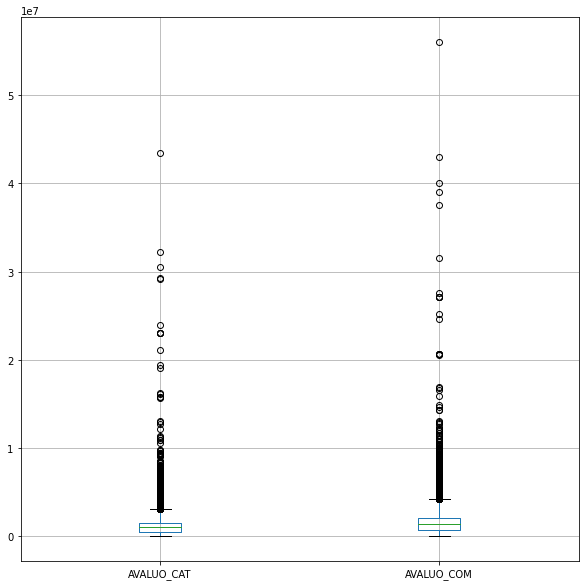

In [50]:
avaluo[['AVALUO_CAT', 'AVALUO_COM']].boxplot(figsize=(10,10))

In [51]:
pd.concat(
    [avaluo[['AVALUO_CAT', 'AVALUO_COM']].quantile(np.linspace(0,1,21)).astype('int64'),
    estrato_intersectado[['y']].quantile(np.linspace(0,1,21)).astype('int64')],
    axis=1)

,AVALUO_CAT,AVALUO_COM,y
0.00,0,0,55423
0.05,104548,129800,1195852
0.10,234036,305732,1447688
0.15,324000,450000,1652173
0.20,399600,550000,1833333
0.25,487016,652376,2031250
0.30,575163,794500,2222222
0.35,670829,920000,2400000
0.40,791547,1095908,2594731
0.45,910000,1279559,2782608


In [52]:
avaluo = avaluo[
    (avaluo['AVALUO_CAT']<avaluo['AVALUO_CAT'].quantile(0.99)) &
    (avaluo['AVALUO_COM']<avaluo['AVALUO_COM'].quantile(0.99))
]

In [111]:
avaluo_intersectado = geopandas.sjoin(left_df=estrato_intersectado.drop(columns='index_right'), right_df=avaluo, how='left', op='intersects')

ipykernel_launcher:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326



In [112]:
avaluo_intersectado[avaluo_intersectado['AVALUO_COM'].notna()][['y', 'AVALUO_CAT', 'AVALUO_COM']].astype('int64')

,y,AVALUO_CAT,AVALUO_COM
1,2093023,980386,1370036
4,1736111,621000,690000
13,1071428,813223,1118613
20,2272727,1089431,1676047
33,1428571,968124,1436027
...,...,...,...
244481,2455721,1945145,3039703
244482,3506668,1326445,1605989
244485,3202390,1387754,1628470
244486,3038545,2019245,2400000


In [113]:
train = avaluo_intersectado.loc[avaluo_intersectado['AVALUO_COM'].notna()]

In [114]:
train.columns

Index(['id', 'area', 'balcon', 'banos', 'banoservicio', 'cuartoservicio',
       'deposito', 'estrato', 'estudio', 'garajes', 'habitaciones',
       'halldealcobas', 'parqueaderovisitantes', 'piso', 'remodelado',
       'saloncomunal', 'terraza', 'tiempodeconstruido', 'vigilancia', 'vista',
       'zonalavanderia', 'valorventa', 'latitud', 'longitud', 'y', 'geometry',
       'ESTRATO', 'index_right', 'OBJECTID', 'MANZANA_ID', 'CP_TERR_AR',
       'GRUPOP_TER', 'AVALUO_COM', 'AVALUO_CAT', 'OBSERVACIO', 'GLOBALID',
       'SHAPE_Leng', 'SHAPE_Area'],
      dtype='object')

In [120]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import GridSearchCV

train = avaluo_intersectado.loc[avaluo_intersectado['AVALUO_COM'].notna()]
X = train[['latitud', 'longitud']].values
y = train[['AVALUO_COM']].values
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
# Se crea el modelo con la base de entrenamiento
# parameters = {
#   'n_neighbors':np.array([4,5,6]),
#   'weights':['distance'],
#   'algorithm': ['brute'],
#   'leaf_size': [1],
#   'p': np.array([2]),
#   'metric':['chebyshev']
#               }
# #Cambiar a GridSearch 
# knn = KNeighborsRegressor()
# cvknn = GridSearchCV(
#   knn, 
#   parameters, 
#   # scoring=make_scorer(mean_absolute_percentage_error), 
#   cv = 2, 
#   n_jobs=-1
# )

(16478, 2)
(7062, 2)
(16478, 1)
(7062, 1)


In [81]:
cvknn.fit(X_train, y_train)

C:\Users\William\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [0.66880699 0.67222677 0.67236793 0.66805945 0.6715247  0.67070062
 0.66719776 0.67032302 0.67287613 0.66880699 0.67222677 0.67236793
        nan        nan        nan 0.6659675  0.66924796 0.67053121
 0.65981878 0.66370803 0.66373563 0.48647167 0.49962802 0.50626647]
  category=UserWarning


GridSearchCV(cv=2, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'algorithm': ['brute'], 'leaf_size': [1],
                         'metric': ['euclidean', 'manhattan', 'chebyshev',
                                    'minkowski', 'wminkowski', 'seuclidean',
                                    'mahalanobis', 'haversine'],
                         'n_neighbors': array([4, 5, 6]), 'p': array([2]),
                         'weights': ['distance']})

In [82]:
cvknn.best_params_

{'algorithm': 'brute',
 'leaf_size': 1,
 'metric': 'chebyshev',
 'n_neighbors': 6,
 'p': 2,
 'weights': 'distance'}

In [124]:
from sklearn.metrics import mean_absolute_error
neigh = KNeighborsRegressor(
    algorithm='brute',
    n_neighbors=5, 
    leaf_size=1,
    p=2,
    weights='distance',
    metric='chebyshev',
    n_jobs=-1)
neigh.fit(X_train, y_train.ravel())
y_pred = neigh.predict(X_test)
print("R^2: {}".format(neigh.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.7573729461951373
Root Mean Squared Error: 541916.862426897
Mean absolute percentage error: 1.9507367552839594e+19


In [127]:
valores = avaluo_intersectado.loc[avaluo_intersectado['AVALUO_COM'].isnull(),['latitud', 'longitud']].values

In [129]:
avaluo_intersectado.loc[avaluo_intersectado['AVALUO_COM'].isnull(),'AVALUO_COM'] = neigh.predict(valores)

In [131]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import GridSearchCV

train = avaluo_intersectado.loc[avaluo_intersectado['AVALUO_CAT'].notna(),['AVALUO_CAT', 'latitud', 'longitud']]
X = train[['latitud', 'longitud']].values
y = train[['AVALUO_CAT']].values
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
# Se crea el modelo con la base de entrenamiento

(16478, 2)
(7062, 2)
(16478, 1)
(7062, 1)


In [132]:
from sklearn.metrics import mean_absolute_error
neigh = KNeighborsRegressor(
    algorithm='brute',
    n_neighbors=5, 
    leaf_size=1,
    p=2,
    weights='distance',
    metric='chebyshev',
    n_jobs=-1)
neigh.fit(X_train, y_train.ravel())
y_pred = neigh.predict(X_test)
print("R^2: {}".format(neigh.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.805063105370563
Root Mean Squared Error: 375184.9936032245


In [133]:
valores = avaluo_intersectado.loc[avaluo_intersectado['AVALUO_CAT'].isnull(),['latitud', 'longitud']].values

In [134]:
avaluo_intersectado.loc[avaluo_intersectado['AVALUO_CAT'].isnull(),'AVALUO_CAT'] = neigh.predict(valores)

In [135]:
avaluo_intersectado.columns

Index(['id', 'area', 'balcon', 'banos', 'banoservicio', 'cuartoservicio',
       'deposito', 'estrato', 'estudio', 'garajes', 'habitaciones',
       'halldealcobas', 'parqueaderovisitantes', 'piso', 'remodelado',
       'saloncomunal', 'terraza', 'tiempodeconstruido', 'vigilancia', 'vista',
       'zonalavanderia', 'valorventa', 'latitud', 'longitud', 'y', 'geometry',
       'ESTRATO', 'index_right', 'OBJECTID', 'MANZANA_ID', 'CP_TERR_AR',
       'GRUPOP_TER', 'AVALUO_COM', 'AVALUO_CAT', 'OBSERVACIO', 'GLOBALID',
       'SHAPE_Leng', 'SHAPE_Area'],
      dtype='object')

In [138]:
columns_fill=['CP_TERR_AR', 'GRUPOP_TER']
avaluo_intersectado[columns_fill] = avaluo_intersectado[columns_fill].fillna('No define')

In [ ]:
valorref_path = r'C:\Users\William\Desktop\el algoritmo es correcto\Datos abiertos bogota\valor_ref'
valorref = geopandas.read_file(valorref_path, crs={'init':'epsg:4686'})

In [ ]:
valorref = valorref[valorref['V_REF']<valorref['V_REF'].quantile(0.99)]

In [ ]:
valorref.sample(10000).plot(column='V_REF', figsize=(10,10), legend=True)

In [ ]:
valorref_intersectado = geopandas.sjoin(left_df=avaluo_intersectado.drop(columns='index_right'), right_df=valorref, how='left', op='intersects')

In [ ]:
valorref_intersectado[valorref_intersectado['id']==1204371][['id', 'V_REF', 'ANO']]#.drop_duplicates('id', keep='last')

In [ ]:
avaluo_intersectado.columns

In [ ]:
sin_columnas = [
    'id', 'estrato', 'geometry', 'index_right', 'latitud', 'longitud', 'OBJECTID', 'MANZANA_ID',
    'OBSERVACIO', 'GLOBALID', 'SHAPE_Leng', 'SHAPE_Area']
datos = avaluo_intersectado.drop(columns=sin_columnas)

In [ ]:
datos.columns

In [ ]:
estrato_intersectado2.loc[estrato_intersectado2["habitaciones"]<5,["y","ESTRATO", "habitaciones"]].boxplot(by=["ESTRATO", "habitaciones"], figsize=(10,10))

In [139]:
avaluo_intersectado.columns

Index(['id', 'area', 'balcon', 'banos', 'banoservicio', 'cuartoservicio',
       'deposito', 'estrato', 'estudio', 'garajes', 'habitaciones',
       'halldealcobas', 'parqueaderovisitantes', 'piso', 'remodelado',
       'saloncomunal', 'terraza', 'tiempodeconstruido', 'vigilancia', 'vista',
       'zonalavanderia', 'valorventa', 'latitud', 'longitud', 'y', 'geometry',
       'ESTRATO', 'index_right', 'OBJECTID', 'MANZANA_ID', 'CP_TERR_AR',
       'GRUPOP_TER', 'AVALUO_COM', 'AVALUO_CAT', 'OBSERVACIO', 'GLOBALID',
       'SHAPE_Leng', 'SHAPE_Area'],
      dtype='object')

In [140]:
avaluo_intersectado.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 40267 entries, 0 to 244487
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     40267 non-null  int64   
 1   area                   40267 non-null  float64 
 2   balcon                 40267 non-null  float64 
 3   banos                  40267 non-null  float64 
 4   banoservicio           40267 non-null  float64 
 5   cuartoservicio         40267 non-null  float64 
 6   deposito               40267 non-null  object  
 7   estrato                38801 non-null  float64 
 8   estudio                40267 non-null  float64 
 9   garajes                40267 non-null  object  
 10  habitaciones           40267 non-null  float64 
 11  halldealcobas          40267 non-null  float64 
 12  parqueaderovisitantes  40267 non-null  float64 
 13  piso                   40267 non-null  object  
 14  remodelado             40267 

In [141]:
columnas_eliminar_modelo = [
    'estrato', 'index_right', 'latitud', 'longitud', 
    'geometry', 'OBJECTID', 'MANZANA_ID', 'OBSERVACIO', 
    'GLOBALID', 'SHAPE_Leng', 'SHAPE_Area']
data1 = pd.get_dummies(avaluo_intersectado.drop(columns=columnas_eliminar_modelo), drop_first=True)

In [143]:
data1.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 40267 entries, 0 to 244487
Data columns (total 56 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   id                                              40267 non-null  int64  
 1   area                                            40267 non-null  float64
 2   balcon                                          40267 non-null  float64
 3   banos                                           40267 non-null  float64
 4   banoservicio                                    40267 non-null  float64
 5   cuartoservicio                                  40267 non-null  float64
 6   estudio                                         40267 non-null  float64
 7   habitaciones                                    40267 non-null  float64
 8   halldealcobas                                   40267 non-null  float64
 9   parqueaderovisitantes         

In [144]:
from sklearn.metrics import mean_absolute_percentage_error 
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

X = data1.drop(columns=['y']).values
y = data1[['y']].values

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [145]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(28186, 55)
(12081, 55)
(28186, 1)
(12081, 1)


In [146]:
mod1 = DecisionTreeRegressor(
    criterion='friedman_mse', 
    splitter='best',
    max_depth=70, #70
    min_samples_split=2,
    min_weight_fraction_leaf=0.0,
    max_leaf_nodes=None,
    max_features='auto', #None
    min_impurity_decrease=0
).fit(X_train, y_train)

In [147]:
mean_absolute_percentage_error(y_train, mod1.predict(X_train))

4.647117603891855e-12

In [148]:
mean_absolute_percentage_error(y_test, mod1.predict(X_test))*100

1.0757123207530295

In [ ]:
avaluocatastral_path = r'C:\Users\William\Desktop\el algoritmo es correcto\Datos abiertos bogota\avaluo'
avaluocatastral = geopandas.read_file(avaluocatastral_path, crs={'init':'epsg:4686'})

In [ ]:
avaluocatastral

In [ ]:
estrato_intersectado = geopandas.sjoin(left_df=casas, right_df=estratificacion, how='left', op='intersects')

In [ ]:
estrato_intersectado = estrato_intersectado.drop(columns=['index_right', 'CODIGO_MAN', 'CODIGO_ZON', 'CODIGO_CRI', 'NORMATIVA',
       'ACTO_ADMIN', 'NUMERO_ACT', 'FECHA_ACTO', 'ESCALA_CAP', 'FECHA_CAPT',
       'RESPONSABL', 'SHAPE_Leng', 'SHAPE_Area'])

In [ ]:
avaluo_intersectado = geopandas.sjoin(left_df=estrato_intersectado, right_df=avaluocatastral, how='left', op='intersects')

In [ ]:
avaluo_intersectado[
    (avaluo_intersectado['piso'].isin([1,2,3,4]))].groupby(['CP_TERR_AR', 'piso', 'GRUPOP_TER'], as_index=False, dropna=False).ESTRATO.count().ESTRATO.sum()

In [ ]:
# prueba.groupby(['habitaciones'], as_index=False, dropna=False).agg(**{'Cantidad': pd.NamedAgg('estrato', 'count')})
prueba.info()